<h1 style="color:red" align="center">Neural Networks: The basics made for all</h1>
<p align="center">By Bastien Lhopitallier and Robin Sobczyk</p>

<h2 style="color:green" align="center">Course 3: Technical limits of AI</h2>

Here are the topics we will cover in this course:
- explainability of a neural network model
- trust in its results and capacity to correctly solve its task (proxy values)
- how to realise a basic analysis of the activations of a network with heatmaps
- an example of one of the risks of neural networks: malicious sample optimization

In [1]:
# Imports for the code
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image

%matplotlib inline

<h3 style="color:red">About Google Colab</h3>

Running notebooks on Google Colab is not necessarily easy, specifically when these notebooks have environment requirements. The following cell should detect if you are running this notebook on Google Colab, and if it is the case, it should enable what is required so that the notebook can run without failing.

Beware that these notebooks are not intrinsically made for Google Colab, and that Google Colab will break the notebook layout and prevent the static pictures from showing. However, this will not prevent the code from executing properly. If you decide to run on Colab (which can be useful to get GPUs), we hence recommend that you follow the results you might get on Colab along with a local version of this notebook, so that you can enjoy both the computation speed and the initial course layout and content.

The time of execution of this notebook is estimated to be about 20 mins on CPU.

In [2]:
import os

colab_script = r"""git clone https://github.com/RobinSobczyk/Teaching-Initiation_to_Neural_Networks
mv ./Teaching-Initiation_to_Neural_Networks/materials ./
rm -r ./Teaching-Initiation_to_Neural_Networks
"""

on_colab = os.getenv("COLAB_RELEASE_TAG") is not None
if on_colab :
    os.system(colab_script)

<h3 style="color:skyblue">Explainability, trust and proxy values of a neural network model</h3>

When desinging and training a neural network for a given task, what is usually done is that its learnable parameters are gradually tuned according to a loss function until it reaches an acceptable level of performance. This already supposes that you have a good enough understanding of the task to be able to design a suitable loss function. But after training your network for hundreds of thousands of iterations, what can you tell about its reasoning? Can we learn anything about the algorithms it has learned through its parameters? Very often, the answer is no! Most neural networks are considered "black boxes", that is, models that take inputs and return solutions without you having the slightest idea how the solution was created. Indeed, if we look "inside" a network, all we will find are tensors of numbers, without any meaning for us humans whatsoever. In fact, not much can be done about explainability.

But then, how can we be sure that our model actually solves the task it has been created for and not another one that is close? How can we trust our model to provide us with a correct solution at all times? In fact, some of the tasks that we want to solve are so hard to properly describe and to formalize that [proxy values](https://centerforgov.gitbooks.io/benchmarking/content/Proxy.html) are sometimes used. A proxy value is a quantity that is strongly linked to the task you want to solve. If selected correctly, solving for the proxy calue will give you a good solution for your initial problem. The issue is, a neural network could learn its own proxy values during its training without us noticing it! For example, if your dataset is biased (over- or under-representation of some of the classes), your model could learn an easier proxy value to solve for the most represented class in your dataset, while having abysmal performances on the rest.

Below, we will study one example of how we can use the parameters of a network to try and get a better understanding of how it makes its predictions, and then a way to deceive a network through a careful optimization of an input.

<h3 style="color:skyblue">Study of a network through its activations</h3>

We will now study how to analyse the activations of a convolutional neural network and plot them with heatmaps. The goal is to get insights on which "zones" of an input image are used to make the prediction. The method used is called [Grad-CAM](https://doi.org/10.48550/arXiv.1610.02391) and the CNN that we will study here is a pre-trained ResNet34 model (which means that no training will be done here).

Let's load it with the next cell.

In [3]:
resnet34 = models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

Because no training will be done, we can set the model in evaluation mode, which will disable all gradient computations to gain time (doing this also displays the structure of our model):

In [4]:
resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The goal here is to get the outputs of the model before the softmax operation to use them. We can see that there is no softmax at the end of this specific model, so we can just fetch the outputs without needing other operations. Moreover, the output will be a vector of values of size 1000, which means that this model is made to do image classificaiton between 1000 different classes.

The next cells downloads a dictionnary containing the names of each class:

In [5]:
class_names = pickle.load(
    urllib.request.urlopen(
        "https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl"
    )
)
print(class_names)

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio camelus', 10: 'brambling, Fringilla montifringilla', 11: 'goldfinch, Carduelis carduelis', 12: 'house finch, linnet, Carpodacus mexicanus', 13: 'junco, snowbird', 14: 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 15: 'robin, American robin, Turdus migratorius', 16: 'bulbul', 17: 'jay', 18: 'magpie', 19: 'chickadee', 20: 'water ouzel, dipper', 21: 'kite', 22: 'bald eagle, American eagle, Haliaeetus leucocephalus', 23: 'vulture', 24: 'great grey owl, great gray owl, Strix nebulosa', 25: 'European fire salamander, Salamandra salamandra', 26: 'common newt, Triturus vulgaris', 27: 'eft', 28: 'spotted salamander, Ambystoma maculatum', 29: 'axolotl, mu

Here is a function to preprocess the images in order to use them with `resnet34` (they need to have the correct size and to be normalized):

In [6]:
def preprocess_images_in_folder(path):
    dataset = datasets.ImageFolder(
        path,
        transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),  # Extract a 224x224 subimage
                transforms.ToTensor(),  # Convert to tensor
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),  # Normalise the tensor
            ]
        ),
    )

    return dataset

Let's apply this preprocessing to some images from the [ImageNET](https://www.image-net.org/index.php) dataset:

In [7]:
dataset = preprocess_images_in_folder("materials")

We can show an image from the dataset, along with its preprocessed version (feel free to change the index of the chosen picture):

Original image:


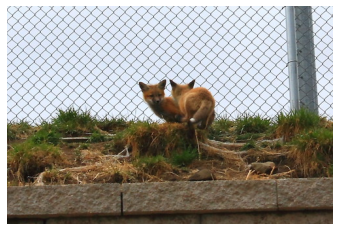

Preprocessed version:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


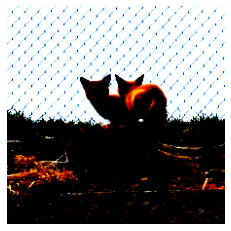

In [8]:
index = 8  # Change this to try out the different images

print("Original image:")
plt.axis("off")
plt.imshow(Image.open(dataset.imgs[index][0]).convert("RGB"))
_ = plt.show()
print("Preprocessed version:")
plt.axis("off")
_ = plt.imshow(dataset[index][0].permute(1, 2, 0))

and the result when passed through our network (we print the first 5 guesses):

In [9]:
def print_top_predictions(output):
    scores, indices = torch.topk(output, 5)
    scores, indices = scores[0].detach().numpy(), indices[0].numpy()
    for i in range(5):
        print(
            f"Top {i+1} ({scores[i]:.2f}): {class_names[indices[i]]} (class n°{indices[i]})"
        )

In [10]:
output = resnet34(dataset[index][0].view(1, 3, 224, 224))
print_top_predictions(output)

Top 1 (16.09): red wolf, maned wolf, Canis rufus, Canis niger (class n°271)
Top 2 (15.05): kit fox, Vulpes macrotis (class n°278)
Top 3 (14.80): red fox, Vulpes vulpes (class n°277)
Top 4 (13.48): dhole, Cuon alpinus (class n°274)
Top 5 (12.69): Shetland sheepdog, Shetland sheep dog, Shetland (class n°230)


To get a better understanding of the Grad-CAM outputs, we'll also need the cropped but unnormalized versions of the images to show the Grad-CAM outputs:

In [11]:
unnormalized_dataset = datasets.ImageFolder(
    "materials",
    transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # same transforms, just without the Normalize
        ]
    ),
)

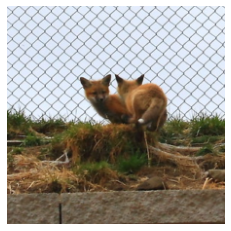

In [12]:
plt.axis("off")
_ = plt.imshow(unnormalized_dataset[index][0].permute(1, 2, 0))

Now let's explain the process of Grad-CAM. We'll take an image and a class name, then pass the image through the model (so that we would be ready for the backpropagation step if we were training the model). Then,  we set all gradients to 0 except for the chosen class for which we set it to 1.

After that, we backpropagate these values, and extract the backpropagated gradients at the layer(s) where we want to plot the heatmap(s).

However, extracting gradients requires additional operations. Indeed, the tensors that contain them can't be accessed directly without disrupting the gradient flow. We need to make use of [hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks)! Hooks are functions that can be registered on a torch Module (the base class for all neural network modules) or a torch Tensor. They can either be a forward hook or a backward hook. The forward hook will be activated during the forward pass, and the same goes for the backward hooks during the backpropagation step.

To successfully apply Grad-CAM, we need to get access to the output (during the forward pass) and the gradient output (during the backward pass) of the chosen module. We'll also plot the outputs for the top 3 predictions of the image.

In [13]:
def Grad_CAM(dataset, img_index, module_to_hook):
    # Dictionnary to save the hook results
    hook_results = {}

    # Make a figure to plot the results
    _, axs = plt.subplots(1, 4, figsize=(20, 6))
    # Print original image
    un_img = unnormalized_dataset[img_index][0].permute(1, 2, 0)
    axs[0].imshow(un_img)
    axs[0].set_title(f"Cropped original image {img_index}")

    # Hook definitions
    def forward_hook(_, __, output):
        # Register the output
        hook_results["forward"] = output

    def backward_hook(_, __, grad_outputs):
        # Register the gradient output
        hook_results["backward"] = grad_outputs[0]

    # Register the hooks
    forward_handle = module_to_hook.register_forward_hook(forward_hook)
    backward_handle = module_to_hook.register_backward_hook(backward_hook)

    # Preprocessed image
    img = dataset[img_index][0].view(1, 3, 224, 224)

    # Get the raw class scores and top 3 possible labels

    # === YOUR CODE ===
    raw_class_scores_tensor = resnet34(img)  # Shape [1, 1000]
    _, top_indices = torch.topk(raw_class_scores_tensor, 3)
    # =================

    # Do Grad-CAM for each of the top 3 predictions
    for i, top_idx in enumerate(top_indices[0]):

        # Set all gradients to 0

        # === YOUR CODE ===
        resnet34.zero_grad()
        # =================

        # Backpropagate just on the top index

        # === YOUR CODE ===
        top_class_output = raw_class_scores_tensor[0, top_idx]
        # =================

        # As it is not a leaf of the backpropagation graph, we use
        # retain_graph=True to avoid the gradient being destroyed
        top_class_output.backward(retain_graph=True)

        # Retrieve the hook outputs
        forw, back = (
            hook_results["forward"].squeeze(),
            hook_results["backward"].squeeze(),
        )

        # Implementation of the equations (1) and (2) from the Grad-CAM paper
        # (cited at the beggining of this part)

        # === YOUR CODE ===
        # Equation (1) of the paper
        neuron_importance_weights = torch.mean(back, dim=(1, 2))
        # Equation (2) of the paper (Hint: use torch.einsum)
        grad_cam = torch.einsum("c,chw->hw", neuron_importance_weights, forw)
        grad_cam = torch.relu(grad_cam)
        # =================

        # Upscale the result, as it is a 7x7 heatmap
        grad_cam = F.interpolate(
            grad_cam[None, None, ...], size=(224, 224), mode="bilinear"
        ).squeeze()
        # Normalize the result
        mini, maxi = torch.min(grad_cam), torch.max(grad_cam)
        grad_cam = (grad_cam - mini) / (maxi - mini)

        # Plot original cropped image and heatmap
        axs[i + 1].imshow(un_img)
        axs[i + 1].imshow(grad_cam.detach().numpy(), cmap="jet", alpha=0.5)
        class_name = class_names[int(top_idx)].split(",")[0]
        axs[i + 1].set_title(class_name)

    # Remove the hooks
    forward_handle.remove()
    backward_handle.remove()
    plt.show()

c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


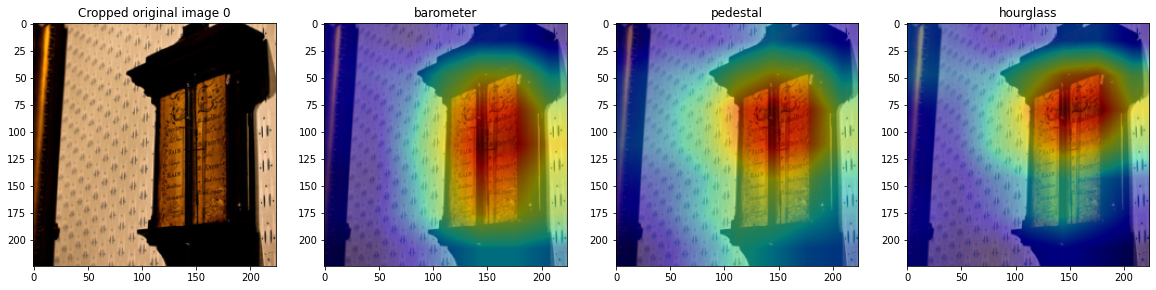

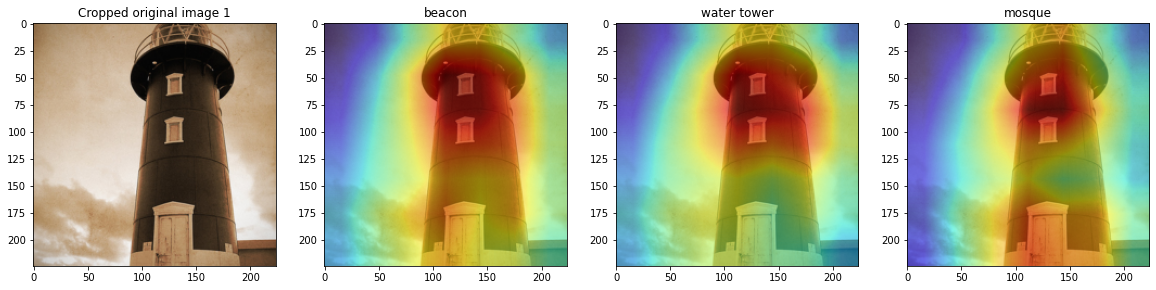

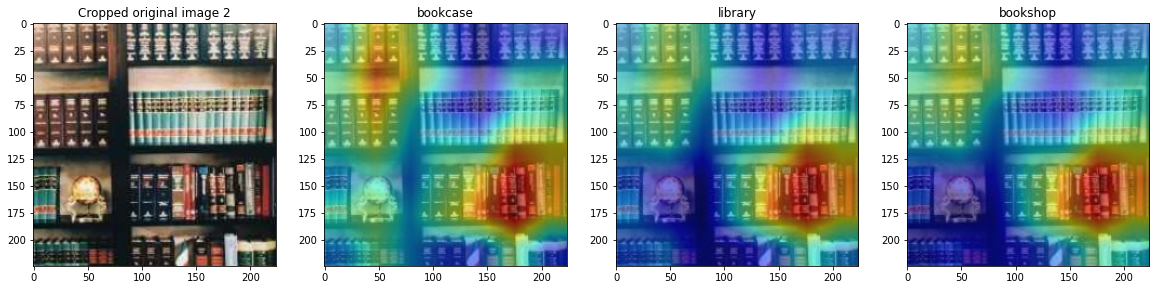

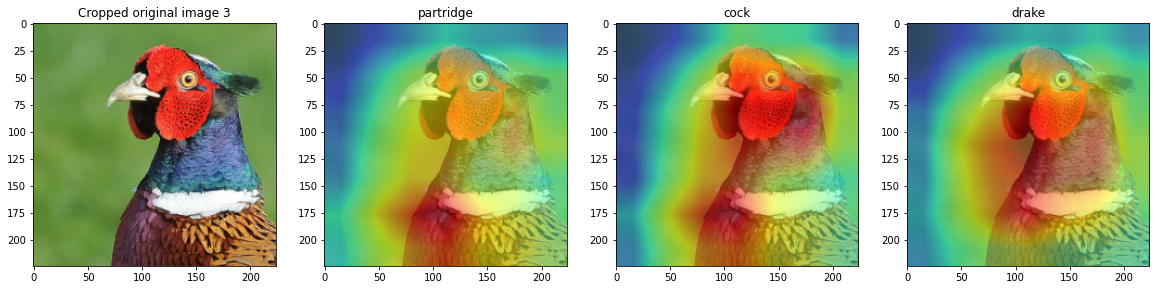

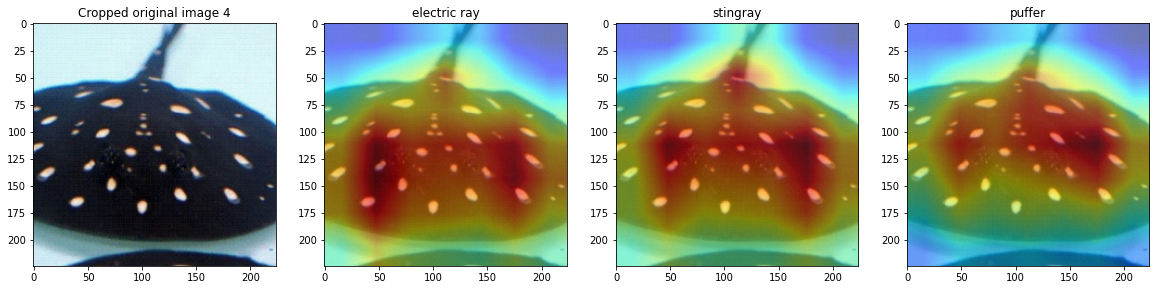

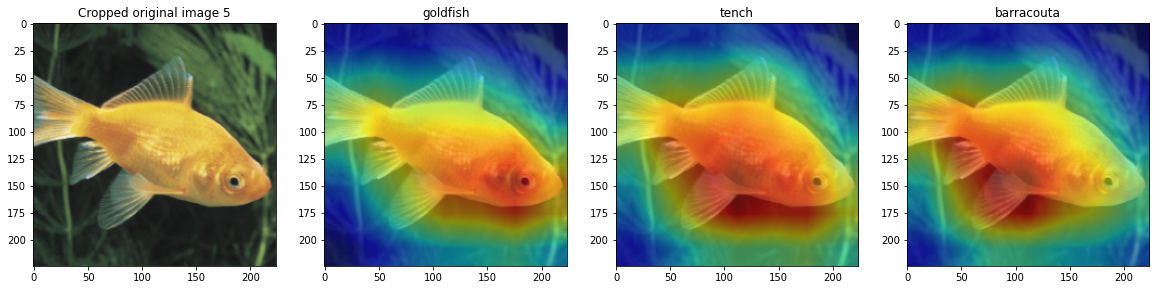

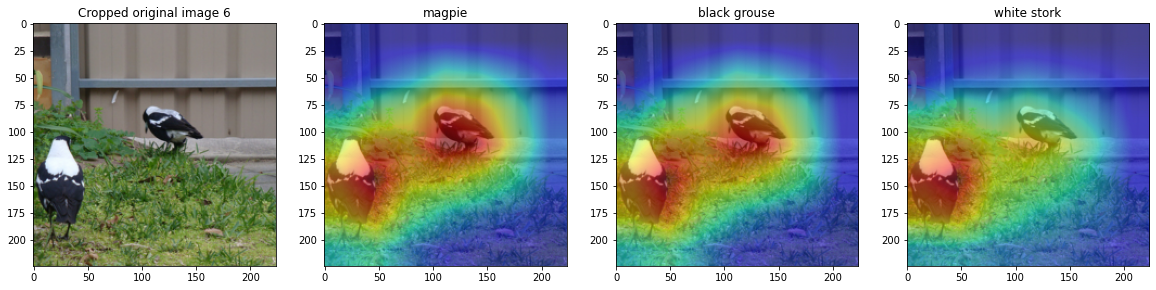

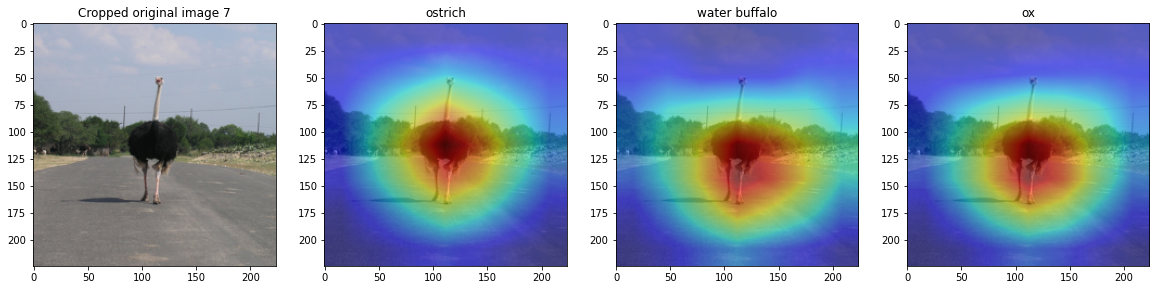

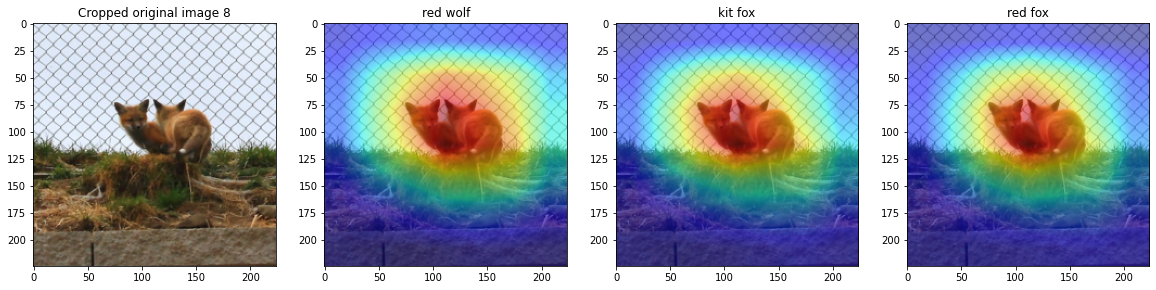

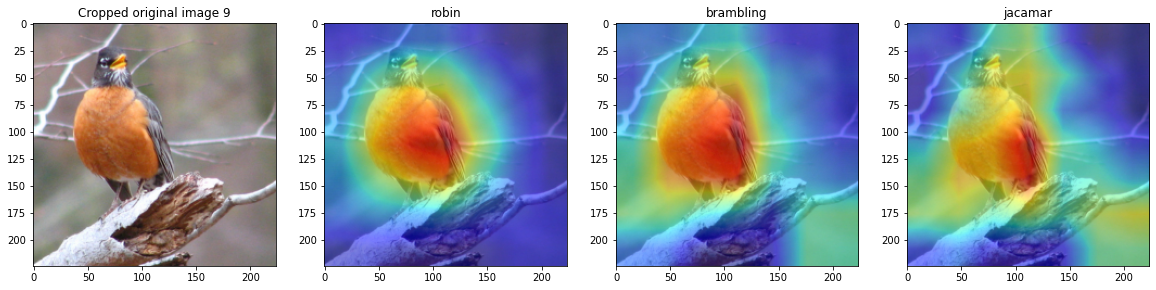

In [14]:
for i in range(len(dataset)):
    Grad_CAM(dataset, i, resnet34.layer4[2].bn2)

We can also do it for other layers, below is an example of layers sorted in their order inside the network:

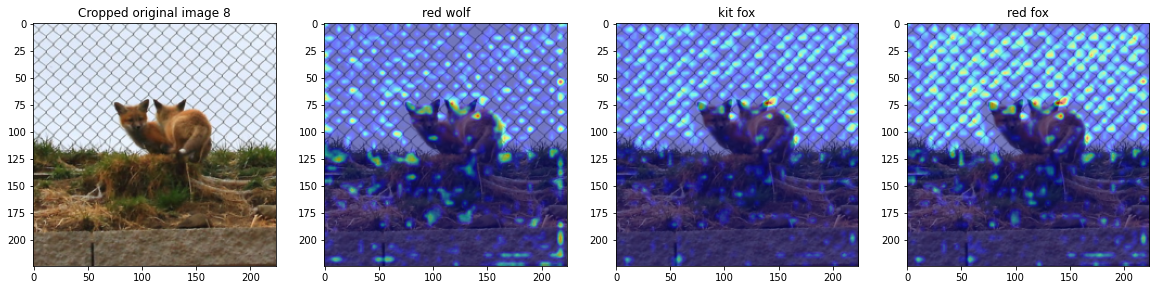

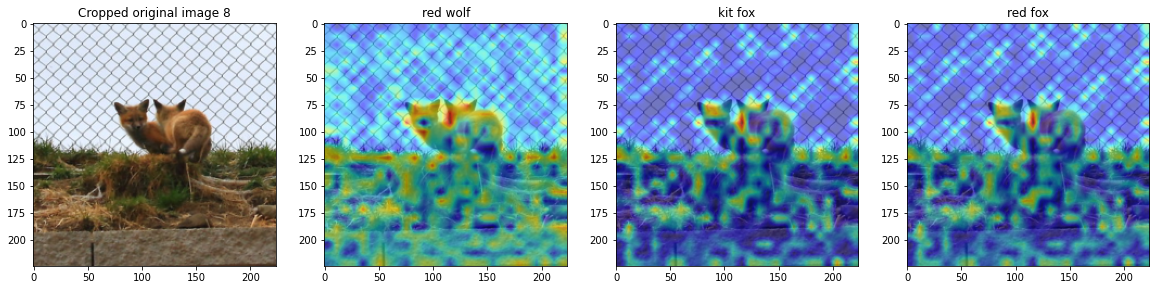

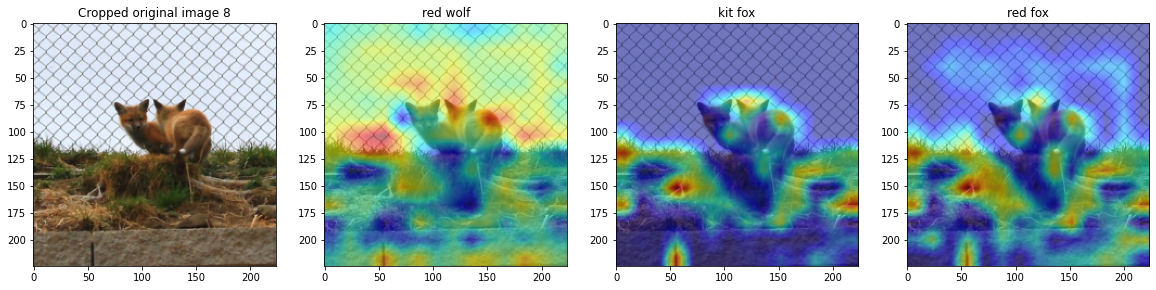

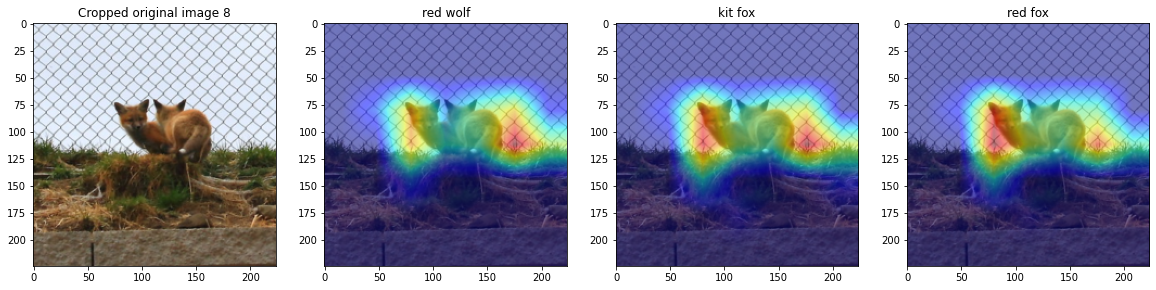

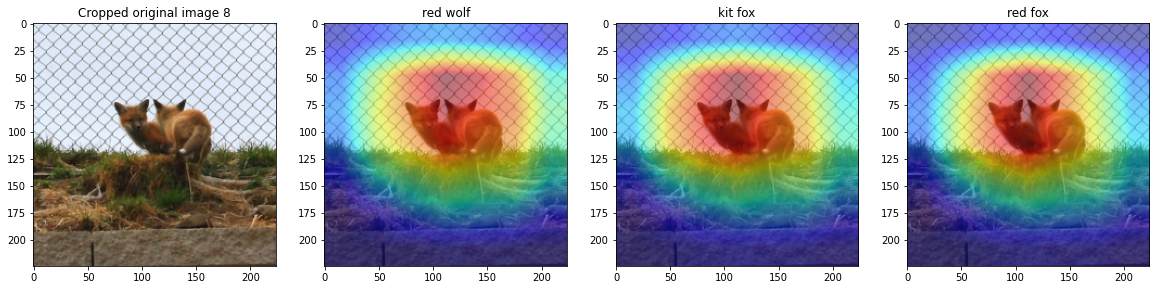

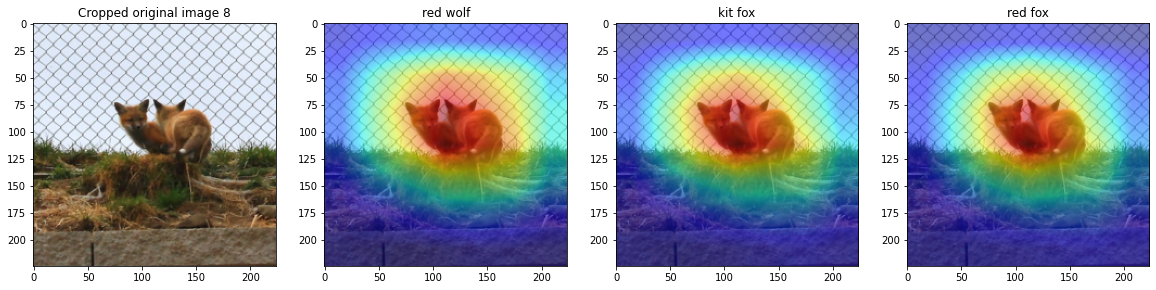

In [15]:
layer_list = [
    resnet34.layer1[2].conv2,
    resnet34.layer2[0].conv1,
    resnet34.layer3[0].conv1,
    resnet34.layer4[1].conv2,
    resnet34.layer4[2].conv2,
    resnet34.layer4[2].bn2,
]

for layer in layer_list:
    Grad_CAM(dataset, index, layer)

We can see how the network gradually uses its learnt features to track down the good points of interest on the image.

Feel free to try different images and layers (the layers are detailed in the cell where we put the model in `eval` mode). To summarize, Grad-CAM major contributions are:
- its applicability to a greater number of CNN networks than before (without having to change the structure of re-train part of or the whole network)
- a fine-grained visualization version (Guided GradCAM)

to be able to provide:
* a robust visualization method
* an understanding of failure cases
* a way to detect dataset bias (over- or under-representation of some classes in a dataset)

<h3 style="color:skyblue">Adversarial poisonning: malicious sample optimization</h3>

In this section, we will take a look at what we can call [adversarial examples](https://doi.org/10.48550/arXiv.1607.02533). The goal of an adversarial example is to modify an input (here, an image) so that the classifier (here, our `resnet34`) outputs a prediciton that is awfully wrong. We'll also see that the modified images are very close to their original counterparts, so that a human person cannot see the difference.

More in detail, here is our setting:
- we cannot modify our network (but we assume that we know its architecture), only the image can be changed
- the prediction of the network for both original and modified images should be different.

For that, we will implement the equation described in Section 2.1 of the paper, called "Fast gradient sign method". The goal is to change the image so that we increase the loss instead of decreasing it, so that the correct prediction becomes less likely to be selected. Thus, we will compute the gradient with respect to the image and shift the original image following this gradient.

But first, let's deactivate the training for our network parameters, as we are not allowed to change them:

In [16]:
for param in resnet34.parameters():
    param.requires_grad = False

We implement the attack in the following cell. Remember, if we denote $L(x,y,\theta)$ the loss (taking as inputs the original image $x$, its prediction $y$ and the network parameters $\theta$, that we aren't allowed to modify), then the adversarial image $x_{adv}$ is created following this formula:
$$
x_{adv} = Clip(x + \epsilon \times \text{sign}(\nabla_x L(x,y,\theta)), 0, 1)
$$
(the clipping function is there to ensure that we still get a valid image in the end)

In [17]:
def FGSM(image, epsilon, grad_image):
    # === YOUR CODE ===

    # Get the sign of the gradient (element-wise)
    grad_sign = torch.sign(grad_image)

    # Create the perturbed image by adjusting each pixel of the input image
    modified_image = image + epsilon * grad_sign

    # Clipping to ensure the output is still a avalid image
    modified_image = torch.clip(modified_image, 0, 1)

    # =================

    # Return the result
    return modified_image

We then need to compute the loss to be able to get access to its gradient for the attack:

In [18]:
# Change these values to try out the different images
index = 8
idx = 271  # should be equal to the top prediction class number, here the red wolf

criterion = nn.CrossEntropyLoss()  # Our loss
original_image = dataset[index][0].view(1, 3, 224, 224)
original_image.requires_grad = True
output = resnet34(original_image)
target_class = torch.tensor([idx])

loss = criterion(output, target_class)
resnet34.zero_grad()
loss.backward()

print_top_predictions(output)

Top 1 (16.09): red wolf, maned wolf, Canis rufus, Canis niger (class n°271)
Top 2 (15.05): kit fox, Vulpes macrotis (class n°278)
Top 3 (14.80): red fox, Vulpes vulpes (class n°277)
Top 4 (13.48): dhole, Cuon alpinus (class n°274)
Top 5 (12.69): Shetland sheepdog, Shetland sheep dog, Shetland (class n°230)


Let's build the modified image. For that, you can gradually increase `epsilon` until the top prediction isn't the original one anymore:

In [19]:
epsilon = 0.0012
modified_image = FGSM(original_image, epsilon, original_image.grad)

modified_output = resnet34(modified_image)
print_top_predictions(modified_output)

Top 1 (10.76): chainlink fence (class n°489)
Top 2 (10.14): lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens (class n°387)
Top 3 (9.76): red fox, Vulpes vulpes (class n°277)
Top 4 (8.60): red wolf, maned wolf, Canis rufus, Canis niger (class n°271)
Top 5 (8.03): cougar, puma, catamount, mountain lion, painter, panther, Felis concolor (class n°286)


Let's take a look at the gradient sign we added to the image and the result:

Original (unnormalized) image:


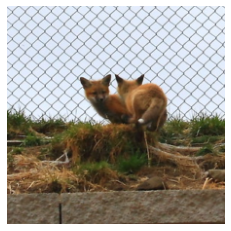

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gradient sign:


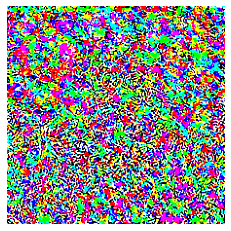

Modified (unnormalized) image:


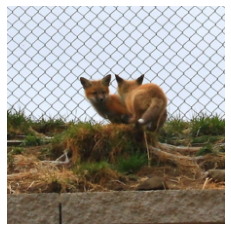

In [20]:
original_unnorm_image = unnormalized_dataset[index][0]

print("Original (unnormalized) image:")
plt.axis("off")
plt.imshow(original_unnorm_image.permute(1, 2, 0))
_ = plt.show()

print("Gradient sign:")
plt.axis("off")
plt.imshow(torch.sign(original_image.grad.detach()).squeeze().permute(1, 2, 0))
_ = plt.show()

print("Modified (unnormalized) image:")
modified_unnorm_image = FGSM(original_unnorm_image, epsilon, original_image.grad)
plt.axis("off")
_ = plt.imshow(modified_unnorm_image.squeeze().permute(1, 2, 0))

Can you tell the difference between the two images? Also, here we just shifted the gradient away from the correct value, but what if instead of that we shifted it towards another class? This is called "Iterative FGSM", and we'll try it now:

In [21]:
# Pick a class (select it yourself or pick at random like below)
target_class_idx = np.random.randint(1000)
print(f"Target class: {class_names[target_class_idx]} (n°{target_class_idx})")

# Define our optimzer (stochastic gradient descent) and the target
shifted_image = dataset[index][0].view(1, 3, 224, 224)
shifted_image.requires_grad = True
optimizer = torch.optim.SGD([shifted_image], lr=0.01)
target_class = torch.tensor([target_class_idx])

# Shift our image towards the new class:
for i in range(1000):
    output = resnet34(shifted_image)
    loss = criterion(output, target_class)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # We use softmax values as they're contained within [0, 1]
    softmax_output = F.softmax(output, dim=1).data.squeeze()
    softmax_output, idx = softmax_output.sort(0, True)
    softmax_output, idx = softmax_output.numpy(), idx.numpy()

    # Print the results of the shifting every 20 iterations
    if i % 20 == 0:
        print(
            f"Iteration {i} | {class_names[idx[0]]} ({softmax_output[0]:.3f}), loss: {loss.item():.3f}"
        )

    # Stop when the target class is reached with high enough probability
    if idx[0] == target_class_idx and softmax_output[0] > 0.7:
        print(
            f"Iteration {i} | {class_names[idx[0]]} ({softmax_output[0]:.3f}), loss: {loss.item():.3f}"
        )
        break

Target class: sunscreen, sunblock, sun blocker (n°838)
Iteration 0 | red wolf, maned wolf, Canis rufus, Canis niger (0.547), loss: 18.373
Iteration 20 | red wolf, maned wolf, Canis rufus, Canis niger (0.310), loss: 12.969
Iteration 40 | chainlink fence (0.240), loss: 11.045
Iteration 60 | chainlink fence (0.249), loss: 9.990
Iteration 80 | chainlink fence (0.232), loss: 9.174
Iteration 100 | chainlink fence (0.213), loss: 8.448
Iteration 120 | chainlink fence (0.203), loss: 7.765
Iteration 140 | chainlink fence (0.194), loss: 7.082
Iteration 160 | chainlink fence (0.187), loss: 6.477
Iteration 180 | chainlink fence (0.176), loss: 5.917
Iteration 200 | chainlink fence (0.164), loss: 5.368
Iteration 220 | basenji (0.149), loss: 4.780
Iteration 240 | basenji (0.153), loss: 4.196
Iteration 260 | basenji (0.148), loss: 3.651
Iteration 280 | basenji (0.126), loss: 3.168
Iteration 300 | basenji (0.113), loss: 2.728
Iteration 320 | basenji (0.101), loss: 2.340
Iteration 340 | sunscreen, sunblo

In [22]:
print_top_predictions(output)

Top 1 (10.54): sunscreen, sunblock, sun blocker (class n°838)
Top 2 (7.30): conch (class n°112)
Top 3 (6.98): basenji (class n°253)
Top 4 (6.92): Ibizan hound, Ibizan Podenco (class n°173)
Top 5 (6.91): African chameleon, Chamaeleo chamaeleon (class n°47)


Our model now predicts a completely different class for our image, without interfering with the model weights! Let's look at the original input image (cropped and normalized) versus the malicious one:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original (preprocessed) version:


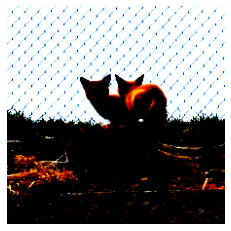

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shifted (preprocessed) version:


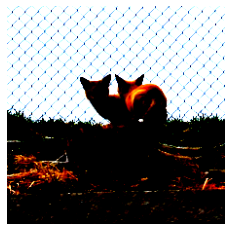

In [23]:
print("Original (preprocessed) version:")
plt.axis("off")
plt.imshow(dataset[index][0].permute(1, 2, 0))
_ = plt.show()
print("Shifted (preprocessed) version:")
plt.axis("off")
_ = plt.imshow(shifted_image.detach().squeeze().permute(1, 2, 0))

Once again, it's very hard to tell the difference between the original and the modified versions (even more with their normalized counterparts). Thus is a great showcase of the fact that there are a lot of aspects involved in solving a task (here: classification), and that we are far from having a great understanding of all of them.